# Packages

In [24]:
#GENERAL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

#PATH PROCESS
import os
from pathlib import Path
import glob
from scipy.io import loadmat

# IMAGE PROCESSING
import cv2
from scipy.ndimage import gaussian_filter

# NEURAL NETWORK
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision

In [25]:
from density_map import gen_density_map_gaussian
from dataloader import DataLoader
from models import MC_CNN
from loss import CombinedLoss

# Explore Dataset

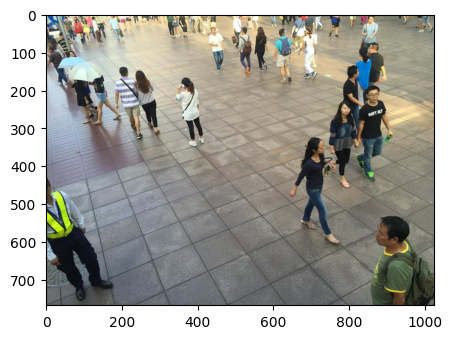

In [26]:
path_img_ex = '../input/shanghaitech/ShanghaiTech/part_B/train_data/images/IMG_6.jpg'
image_ex = cv2.cvtColor(cv2.imread(path_img_ex),cv2.COLOR_BGR2RGB)
figure = plt.figure(figsize=(5,5))
plt.imshow(image_ex)
plt.show()

In [27]:
path_gt_ex = "../input/shanghaitech/ShanghaiTech/part_B/train_data/ground-truth/GT_IMG_6.mat"
gt_ex = loadmat(path_gt_ex)
print('type: ', type(gt_ex))
print(gt_ex.items())

type:  <class 'dict'>
dict_items([('__header__', b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Nov 18 19:55:34 2016'), ('__version__', '1.0'), ('__globals__', []), ('image_info', array([[array([[(array([[  3.94945534, 469.96427015],
                       [919.86056645, 584.69019608],
                       [722.64575163, 353.34204793],
                       [794.70501089, 254.73464052],
                       [866.76427015, 219.65315904],
                       [815.56427015, 156.12723312],
                       [371.83093682, 180.77908497],
                       [251.416122  , 168.45315904],
                       [204.95686275, 154.23093682],
                       [ 12.48278867,  92.36427015],
                       [ 20.54204793,  71.50501089],
                       [ 70.31982571, 107.53464052],
                       [ 43.53464052,  59.06056645],
                       [ 84.18649237,  18.26056645],
                       [100.83834423,  16.18649237],
             

In [28]:
print("Keys:", gt_ex.keys())
gt_coor_ex = gt_ex.get('image_info')[0][0][0][0][0]
print('Shape of coordinates: ', gt_coor_ex.shape)
print("Coordiates:", gt_coor_ex)

Keys: dict_keys(['__header__', '__version__', '__globals__', 'image_info'])
Shape of coordinates:  (36, 2)
Coordiates: [[  3.94945534 469.96427015]
 [919.86056645 584.69019608]
 [722.64575163 353.34204793]
 [794.70501089 254.73464052]
 [866.76427015 219.65315904]
 [815.56427015 156.12723312]
 [371.83093682 180.77908497]
 [251.416122   168.45315904]
 [204.95686275 154.23093682]
 [ 12.48278867  92.36427015]
 [ 20.54204793  71.50501089]
 [ 70.31982571 107.53464052]
 [ 43.53464052  59.06056645]
 [ 84.18649237  18.26056645]
 [100.83834423  16.18649237]
 [111.44575163   8.48278867]
 [ 78.02352941  12.09760349]
 [ 54.9124183   12.69019608]
 [840.216122   107.06056645]
 [872.92723312  92.36427015]
 [858.82352941  18.94204793]
 [126.8142054   12.13688273]
 [133.75126834   2.47054906]
 [691.94507453  46.38263697]
 [623.40561399  49.96305655]
 [565.6074122   43.3137059 ]
 [521.1079117   43.82519441]
 [442.33868093  45.26375585]
 [360.88413547   1.34567393]
 [173.55146814   6.99802159]
 [324.95206

Text(0.5, 1.0, 'Image and Coordinate')

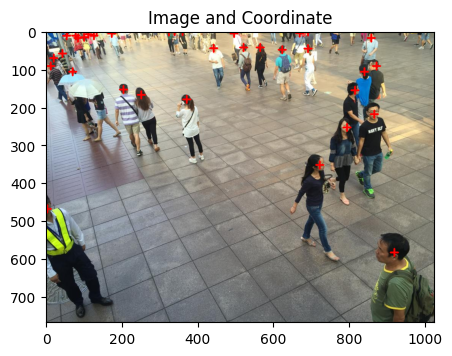

In [29]:
figure = plt.figure(figsize=(5,5))

for x_cor, y_cor in gt_coor_ex:
    cv2.drawMarker(image_ex, (int(x_cor), int(y_cor)),(255, 0, 0),thickness=3)

plt.imshow(image_ex)
plt.title("Image and Coordinate")

# Density Map

max1 :  tensor(1.)
max2 :  0.012646893
min1 :  tensor(0.)
min2 :  0.0


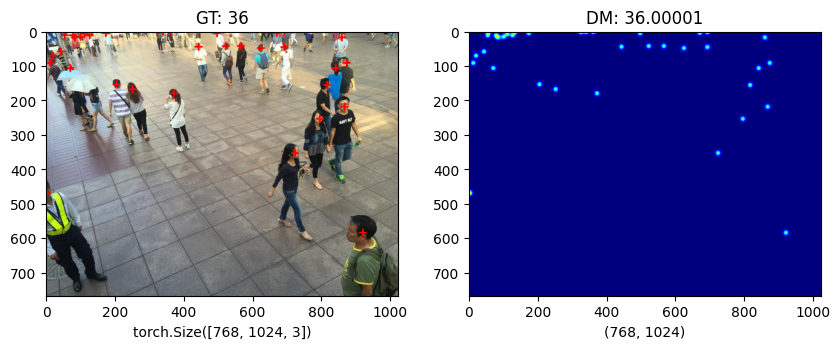

In [30]:
density_map_ex = gen_density_map_gaussian(image_ex, gt_coor_ex, 5)

figure = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
image_ex = torch.tensor(image_ex/255, dtype=torch.float)
plt.xlabel(image_ex.shape)
plt.title('GT: '+str(gt_coor_ex.shape[0]))
plt.imshow(image_ex)

plt.subplot(1,2,2)
plt.xlabel(density_map_ex.shape)
plt.title('DM: '+str(np.sum(density_map_ex)))
plt.imshow(density_map_ex, cmap="jet")

print('max1 : ', image_ex.max())
print('max2 : ', density_map_ex.max())
print('min1 : ', image_ex.min())
print('min2 : ', density_map_ex.min())

# Data Loader

../input/shanghaitech/ShanghaiTech/part_B/test_data/


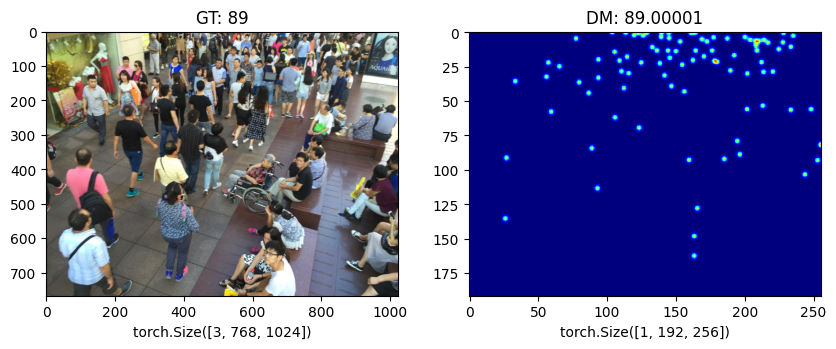

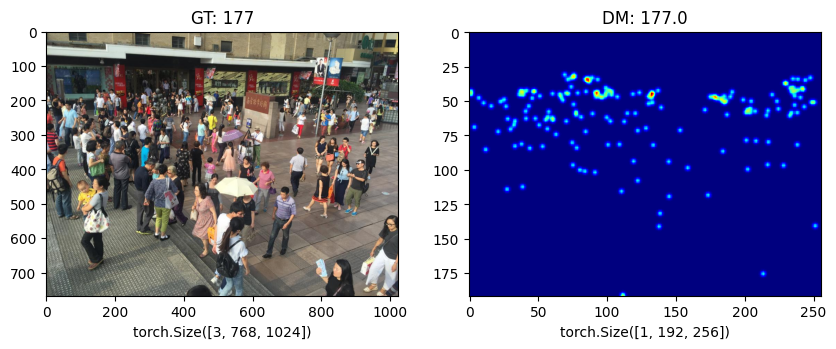

In [31]:
root_dir = "../input/shanghaitech/ShanghaiTech/part_B/test_data/"
dataset = DataLoader(root_dir, gt_downsample=4, shuffle=True)
print(dataset.root_dir)

for i, (img, gt_dmap, n_people) in enumerate(dataset):
  plt.figure(figsize=(10, 5))
  plt.subplot(1,2,1)
  plt.xlabel(img.shape)
  plt.title('GT: ' + str(n_people))
  plt.imshow(img.permute(1, 2, 0))

  plt.subplot(1,2,2)
  plt.xlabel(gt_dmap.shape)
  plt.title('DM: ' + str(np.sum(gt_dmap.numpy())))
  plt.imshow(gt_dmap.permute(1, 2, 0), cmap="jet")
  plt.show()

  if i > 0:
    #print('type of img: ', type(img))
    #print('type of dmap: ', type(gt_dmap))
    #print('shape of img: ', img.shape)
    break

# Model

In [32]:
img=torch.rand((1,3,768,1024),dtype=torch.float)
mcnn=MC_CNN()
out_dmap=mcnn(img)
print(out_dmap.shape)

torch.Size([1, 1, 192, 256])


# Data for traning, validation, and testing

In [33]:
batch_size = 8
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

train_root_dir = "../input/shanghaitech/ShanghaiTech/part_B/train_data/"
init_training_set = DataLoader(train_root_dir, gt_downsample=4, shuffle=True)

# split part of the training set as validation set
train_size = int(0.9 * len(init_training_set))
val_size = len(init_training_set) - train_size

train_indices = list(range(train_size))
val_indices = list(range(train_size, len(init_training_set)))
train_dataset = torch.utils.data.dataset.Subset(init_training_set, train_indices)
val_dataset = torch.utils.data.dataset.Subset(init_training_set, val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_root_dir = "../input/shanghaitech/ShanghaiTech/part_B/test_data/"
test_set = DataLoader(test_root_dir, gt_downsample=4, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

print("Number of batches in train_loader:", len(train_loader))
print("Number of batches in val_loader:", len(val_loader))
print("Number of batches in test_loader:", len(test_loader))

Number of batches in train_loader: 45
Number of batches in val_loader: 5
Number of batches in test_loader: 40


## Show Images and Density Maps

In [34]:
def plot_corresponding_pairs(batch1, batch2, plot_map='jet'):
    num_images = batch1.shape[0] # can change to 4 if for entire data set

    fig, axes = plt.subplots(int(np.ceil(num_images/2)), 4)

    for i in range(num_images):
        axes[int(i/4)*2, i%4].imshow(batch1[i].permute(1, 2, 0))
        axes[int(i/4)*2, i%4].axis('off')

        axes[int(i/4)*2+1, i%4].imshow(batch2[i].squeeze().detach().numpy(), cmap=plot_map)
        axes[int(i/4)*2+1, i%4].axis('off')
        axes[int(i/4)*2+1, i%4].set_title('DM: ' + str(np.sum(batch2[i].detach().numpy())))

    plt.tight_layout()
    plt.show()

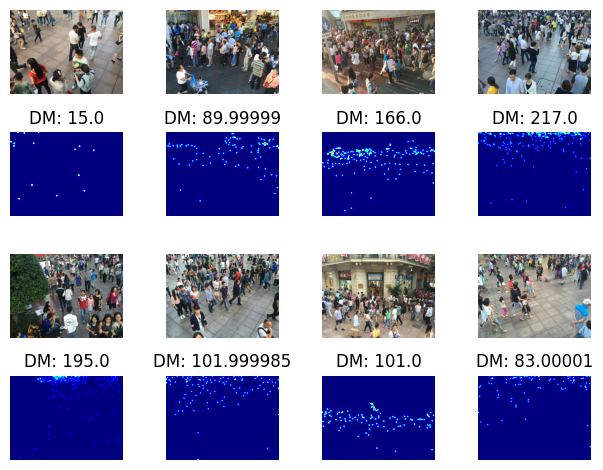

Ground truth counts:    15    90   166   217   195   102   101    83


In [35]:
# Get a batch from the training loader
dataiter = iter(train_loader)
ex_images, ex_dmaps, ex_n_people = next(dataiter)

# Move tensors to CPU if they are on GPU (for plotting)
ex_images = ex_images.cpu()
ex_dmaps = ex_dmaps.cpu()

# Show images and density map
plot_corresponding_pairs(ex_images, ex_dmaps)

# Print Ground truth number of people for each image in the batch
print('Ground truth counts:', ' '.join('%5s' % ex_n_people[j].item() for j in range(len(ex_n_people))))


# Training Phase

In [36]:
num_epochs = 100
#train_losses = np.zeros(num_epochs)
#val_losses = np.zeros(num_epochs)
train_losses = []
val_losses = []
train_mae_losses = []
val_mae_losses = []


model = MC_CNN().to(device)
criterion = CombinedLoss(0.8, 0.2)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
best_val_loss = np.inf
best_nr_epoch = 0

for epoch in range(num_epochs):
    print("Epoch {}:".format(epoch))

    # training phase
    tr_loss_acc = 0.0
    tr_loss_mae_acc = 0.0

    for batch_img, batch_dmap, batch_gts in train_loader:
        # Put data on device
        batch_img, batch_dmap, batch_gts = batch_img.to(device), batch_dmap.to(device), batch_gts.to(device)
        # Predict and get loss
        logits = model(batch_img)
        loss, mae_loss = criterion(logits, batch_dmap, batch_gts)
        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Keep running statistics
        tr_loss_acc += loss.item()
        tr_loss_mae_acc += mae_loss.item()
        #print('acc mae = ', tr_loss_mae_acc)
        

    tr_loss = tr_loss_acc / len(train_loader.dataset) # change to this when entire dataset
    tr_mae = tr_loss_mae_acc / len(train_loader.dataset)
    print('>> TRAIN: Epoch {} | tr_loss:  {:.6f}'.format(epoch, tr_loss))
    print('>> TRAIN: Epoch {} | mae:      {:.6f}'.format(epoch, tr_mae))
    
    # Get validation results
    with torch.inference_mode():
        val_loss_acc = 0.0
        val_loss_mae_acc = 0.0
        
        for batch_img_val, batch_dmap_val, batch_gts_val in val_loader:
            # Put data on device
            batch_img_val, batch_dmap_val, batch_gts_val = batch_img_val.to(device), batch_dmap_val.to(device), batch_gts_val.to(device)

            # Predict and get loss
            logits = model(batch_img_val)
            loss, mae_loss = criterion(logits, batch_dmap_val, batch_gts_val)

            # Keep running statistics
            val_loss_acc += loss.item()
            val_loss_mae_acc += mae_loss.item()

    val_loss = val_loss_acc / len(val_loader.dataset)
    val_mae = val_loss_mae_acc / len(val_loader.dataset)
    print('>> VAL:   Epoch {} | val_loss: {:.6f}'.format(epoch, val_loss))
    print('>> VAL:   Epoch {} | mae:      {:.6f}'.format(epoch, val_mae))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_nr_epoch = epoch
        torch.save(model.state_dict(), './crowd_counting.pth')


    train_losses.append(tr_loss)
    train_mae_losses.append(tr_mae)
    val_losses.append(val_loss)
    val_mae_losses.append(val_mae)
    
print('best training MAE: ', train_mae_losses[best_nr_epoch])  
print('best val MAE:      ', val_mae_losses[best_nr_epoch])  

Epoch 0:
>> TRAIN: Epoch 0 | tr_loss:  4.136031
>> TRAIN: Epoch 0 | mae:      20.680034
>> VAL:   Epoch 0 | val_loss: 1.923994
>> VAL:   Epoch 0 | mae:      9.619868
Epoch 1:
>> TRAIN: Epoch 1 | tr_loss:  2.159154
>> TRAIN: Epoch 1 | mae:      10.795662
>> VAL:   Epoch 1 | val_loss: 2.946929
>> VAL:   Epoch 1 | mae:      14.734540
Epoch 2:
>> TRAIN: Epoch 2 | tr_loss:  1.985380
>> TRAIN: Epoch 2 | mae:      9.926796
>> VAL:   Epoch 2 | val_loss: 1.672209
>> VAL:   Epoch 2 | mae:      8.360946
Epoch 3:
>> TRAIN: Epoch 3 | tr_loss:  1.906257
>> TRAIN: Epoch 3 | mae:      9.531179
>> VAL:   Epoch 3 | val_loss: 1.644359
>> VAL:   Epoch 3 | mae:      8.221695
Epoch 4:
>> TRAIN: Epoch 4 | tr_loss:  2.032352
>> TRAIN: Epoch 4 | mae:      10.161655
>> VAL:   Epoch 4 | val_loss: 2.730614
>> VAL:   Epoch 4 | mae:      13.652968
Epoch 5:
>> TRAIN: Epoch 5 | tr_loss:  1.829808
>> TRAIN: Epoch 5 | mae:      9.148933
>> VAL:   Epoch 5 | val_loss: 1.361860
>> VAL:   Epoch 5 | mae:      6.809201
Epoch

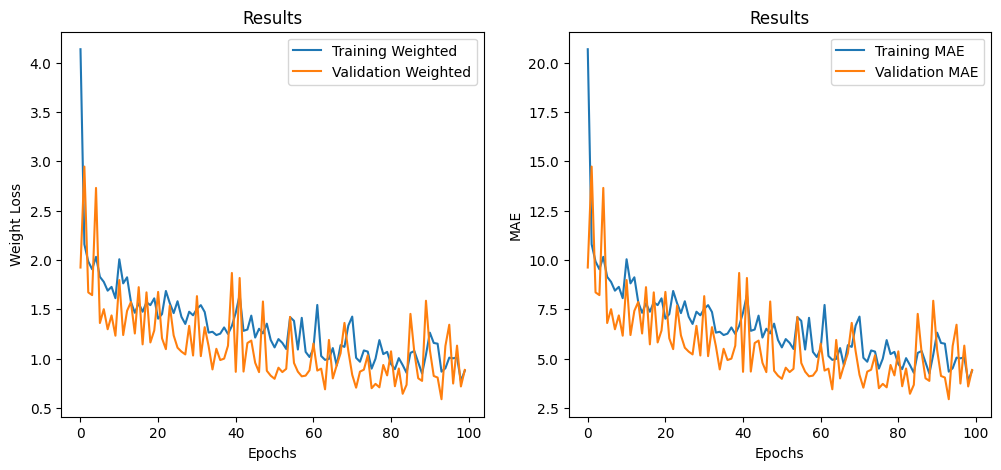

In [37]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Weighted')
plt.plot(val_losses, label='Validation Weighted')
plt.title('Results')
plt.ylabel('Weight Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_mae_losses, label='Training MAE')
plt.plot(val_mae_losses, label='Validation MAE')
plt.title('Results')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend()

plt.show()

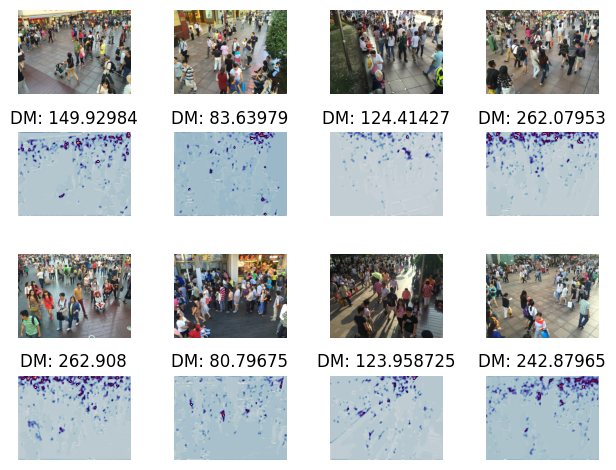

  156   118   108   318   267    79   221   296


In [38]:
best_model = MC_CNN().to(device)
best_model.load_state_dict(torch.load('./crowd_counting.pth'))
# Get some random validation images
dataiter = iter(val_loader)
ex_images, _, ex_gts  = next(dataiter)


# Show images and density map

pred_dms = best_model(ex_images.to(device))
plot_corresponding_pairs(ex_images.cpu(), pred_dms.cpu(), 'twilight')

# Print labels
print(' '.join('%5s' % ex_gts[j].item() for j in range(batch_size)))

# Test


In [39]:
# Load the best model
best_model = MC_CNN().to(device)
best_model.load_state_dict(torch.load('./crowd_counting.pth'))
criterion = nn.L1Loss()

# Initialize test loss accumulator
test_loss_acc = 0.0

# Evaluation mode
best_model.eval()
with torch.inference_mode():
    for batch_img, batch_dmap, batch_gts in test_loader:
        # Move data to device
        batch_img, batch_dmap, batch_gts = batch_img.to(device), batch_dmap.to(device), batch_gts.to(device)

        # Predict and compute loss
        logits = best_model(batch_img)
        loss = criterion(torch.squeeze(logits.sum(dim=(2, 3))), batch_gts)

        # Accumulate test loss with batch size
        test_loss_acc += loss.item() * batch_img.size(0)

# Calculate the final average test MAE
test_mae = test_loss_acc / len(test_loader.dataset)

# Print results
print(f'TEST: test_MAE: {test_mae:.3f}')


TEST: test_MAE: 33.884


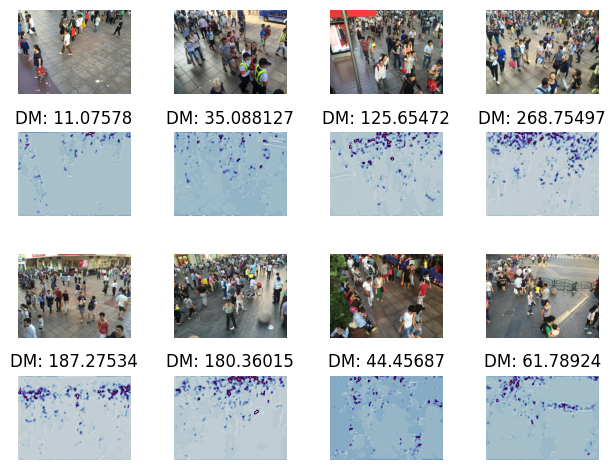

Ground truth counts:    26    41   138   217   144   176    46    70


In [40]:
# Retrieve a batch of images from the test_loader
dataiter = iter(test_loader)
ex_images, _, ex_gts = next(dataiter)

# Generate predictions
ex_images = ex_images.to(device)
pred_dms = best_model(ex_images).cpu()  # Move predictions back to CPU for plotting

# Show images and density maps
plot_corresponding_pairs(ex_images.cpu(), pred_dms, 'twilight')

# Print labels for the ground truth counts
batch_size = ex_images.size(0)
print('Ground truth counts:', ' '.join(f'{ex_gts[j].item():5}' for j in range(batch_size)))
